# Gesture Recognition

In [1]:
import numpy as np
import os
from imageio import imread
import datetime
import os
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('../input/gesture-detection/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../input/gesture-detection/Project_data/val.csv').readlines())
train_path = '../input/gesture-detection/Project_data/train'
val_path = '../input/gesture-detection/Project_data/val'
batch_size = 40

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
imagesize_y=120
imagesize_z=120

In [5]:
def generator(input_path, list_folders, batch_size):
    print( 'Source path = ',input_path, '; batch size =', batch_size)
    imgsize_y=120
    imgsize_z=120
    img_idx = np.arange(1,30,2) 
    while True:
        t = np.random.permutation(list_folders)
        num_batches = len(list_folders)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),imgsize_y,imgsize_z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(input_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                #imgs = os.listdir(input_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(input_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = resize(image, (imgsize_y,imgsize_z,3))
                    image_channel_0 = image[:,:,0]
                    image_channel_1 = image[:,:,1]
                    image_channel_2 = image[:,:,2]
                    batch_data[folder,idx,:,:,0] = (image_channel_0 - np.percentile(image_channel_0,5))/(np.percentile(image_channel_0,95) - np.percentile(image_channel_0,5))
                    batch_data[folder,idx,:,:,1] = (image_channel_1 - np.percentile(image_channel_1,5))/(np.percentile(image_channel_1,95) - np.percentile(image_channel_1,5))
                    batch_data[folder,idx,:,:,2] = (image_channel_2 - np.percentile(image_channel_2,5))/(np.percentile(image_channel_2,95) - np.percentile(image_channel_2,5))
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
    remainig_image = len(list_folders) % batch_size
    if remainig_image != 0:
        
            batch_size=remainig_image
            batch_data = np.zeros((batch_size,len(img_idx),imgsize_y,imgsize_z,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(input_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(input_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    print(input_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    image = resize(image, (imgsize_y,imgsize_z,3))
                    image_channel_0 = image[:,:,0]
                    image_channel_1 = image[:,:,1]
                    image_channel_2 = image[:,:,2]
                    batch_data[folder,idx,:,:,0] = image_channel_0 - np.percentile(image_channel_0,5)/ np.percentile(image_channel_0,95) - np.percentile(image_channel_0,5)
                    batch_data[folder,idx,:,:,1] = image_channel_1 - np.percentile(image_channel_1,5)/ np.percentile(image_channel_1,95) - np.percentile(image_channel_1,5)
                    batch_data[folder,idx,:,:,2] = image_channel_2 - np.percentile(image_channel_2,5)/ np.percentile(image_channel_2,95) - np.percentile(image_channel_2,5)
                    

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 40


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.applications import mobilenet
import tensorflow as tf
from tensorflow.keras import regularizers

num_classes = 5

# We are using transfer learning with Mobilenet network

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

def get_model_mobile():
    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(15, imagesize_y, imagesize_z, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(32, return_sequences = True))
    model.add(Dropout(0.25))
    model.add(GRU(64))
    model.add(Dropout(0.25))
    model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.L2(0.01),activity_regularizer=regularizers.L2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

2022-05-16 17:10:16.953910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 17:10:17.065745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 17:10:17.066941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 17:10:17.068476: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

17235968/17225924 [==============================] - 0s 0us/step


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
# Get the model
model = get_model_mobile()

# compile it
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0004), metrics=['categorical_accuracy'])

# summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 15, 32)            101568    
_________________________________________________________________
dropout (Dropout)            (None, 15, 32)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

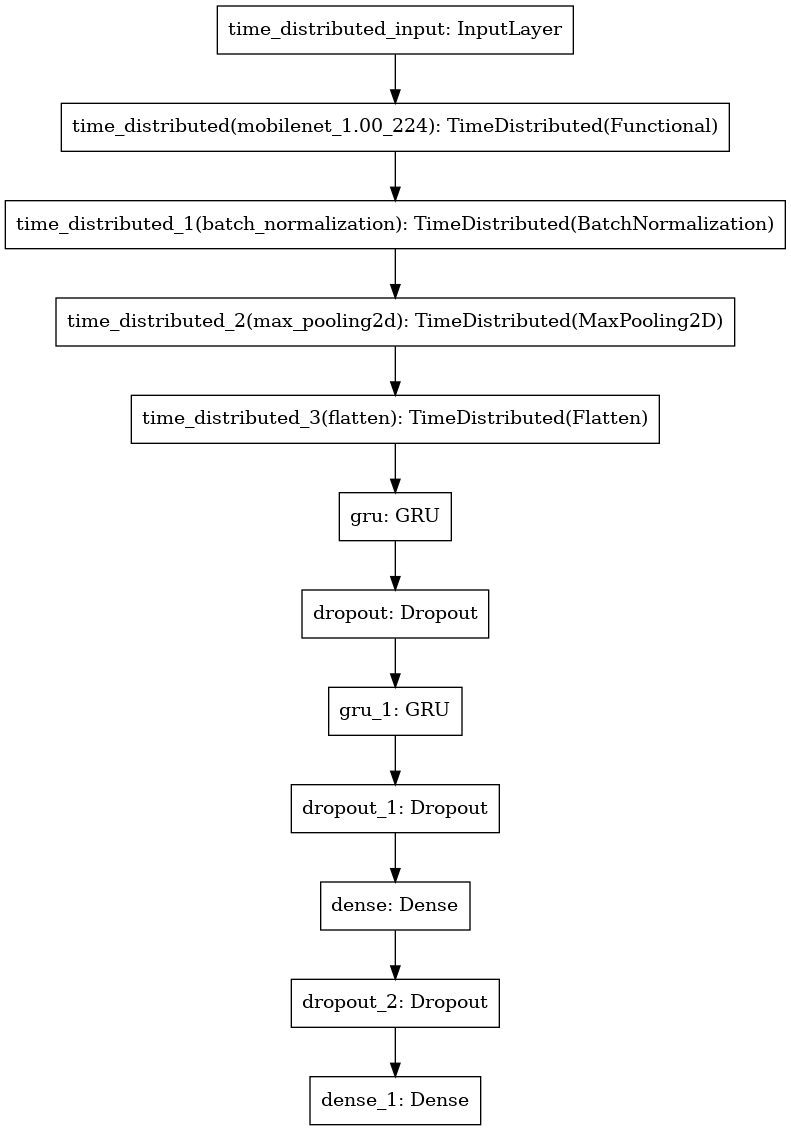

In [9]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png")

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=5, min_lr=0.0001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  ../input/gesture-detection/Project_data/train ; batch size = 40


2022-05-16 17:10:35.620254: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-05-16 17:10:43.358864: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


17/17 [==============================] - 234s 14s/step - loss: 2.0092 - categorical_accuracy: 0.2721 - val_loss: 1.8408 - val_categorical_accuracy: 0.5000

Epoch 00001: val_categorical_accuracy improved from -inf to 0.50000, saving model to model_init_2022-05-1617_10_16.333764/model-00001-2.00922-0.27206-1.84084-0.50000.h5
Epoch 2/40
17/17 [==============================] - 163s 10s/step - loss: 1.7624 - categorical_accuracy: 0.4721 - val_loss: 1.7700 - val_categorical_accuracy: 0.5417

Epoch 00002: val_categorical_accuracy improved from 0.50000 to 0.54167, saving model to model_init_2022-05-1617_10_16.333764/model-00002-1.76238-0.47206-1.76997-0.54167.h5
Epoch 3/40
17/17 [==============================] - 161s 10s/step - loss: 1.5252 - categorical_accuracy: 0.6338 - val_loss: 1.5185 - val_categorical_accuracy: 0.7083

Epoch 00003: val_categorical_accuracy improved from 0.54167 to 0.70833, saving model to model_init_2022-05-1617_10_16.333764/model-00003-1.52521-0.63382-1.51850-0.70833.

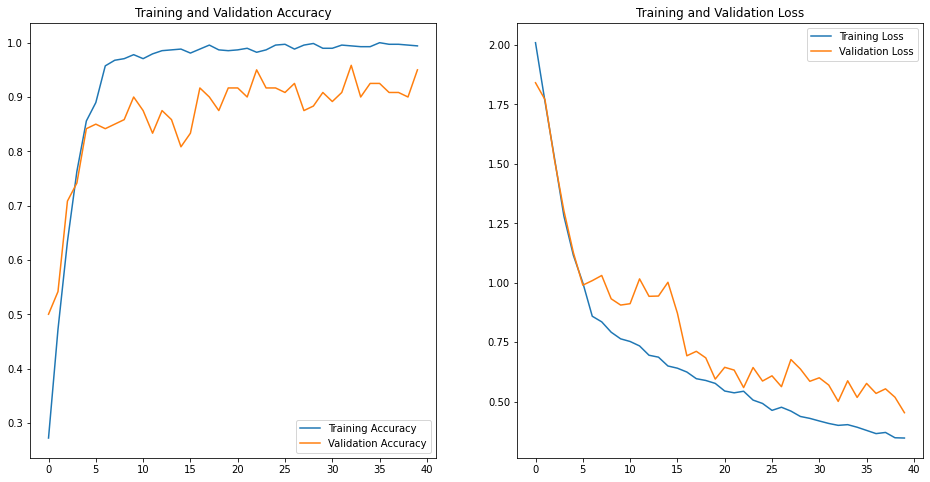

In [14]:
# Plotting Training & validation accuracy/losses

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(num_epochs)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()